In [ ]:
from google.colab import drive
drive.mount("/content/Google_Drive")

Mounted at /content/Google_Drive


# Emotion Analysis

In [ ]:
! wget https://worksheets.codalab.org/rest/bundles/0x97c870dd60eb4f0fa53f257978851c60/contents/blob/glove.6B.200d.txt -P data/
# ! wget https://github.com/anmol-sinha-coder/Sentiment_Emotion_Analysis/raw/main/Multi_Emotion_Analyzer/emotion_model.pth
! cp -ra Google_Drive/MyDrive/ADNN/emotion_model.pth /content/
! cp -ra Google_Drive/MyDrive/ADNN/sentiment_model.pt /content/
! pip install transformers

--2022-04-02 10:34:20--  https://worksheets.codalab.org/rest/bundles/0x97c870dd60eb4f0fa53f257978851c60/contents/blob/glove.6B.200d.txt
Resolving worksheets.codalab.org (worksheets.codalab.org)... 13.68.212.115
Connecting to worksheets.codalab.org (worksheets.codalab.org)|13.68.212.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/plain]
Saving to: ‘data/glove.6B.200d.txt’

glove.6B.200d.txt       [   <=>              ] 661.31M  28.8MB/s    in 26s     

2022-04-02 10:34:47 (25.4 MB/s) - ‘data/glove.6B.200d.txt’ saved [693432828]

     |████████████████████████████████| 3.8 MB 11.9 MB/s 
     |████████████████████████████████| 6.5 MB 37.8 MB/s 
     |████████████████████████████████| 895 kB 33.9 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
  Attemp

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from transformers import BertTokenizer,BertModel

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map



def pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True):
    num_embeddings = len(word_to_index) + 1                   
    embedding_dim = word_to_vec_map["cucumber"].shape[0]  #  dimensionality of GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (num_embeddings, embedding_dim)
    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        weights_matrix[index, :] = word_to_vec_map[word]

    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim



def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    """
    m = X.shape[0]  # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):  # loop over training examples
        
        # Convert the ith sentence in lower case and split into a list of words
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
    
    return X_indices


In [ ]:
#X_train, Y_train = read_csv('/content/data/train.csv')
#X_test, Y_test = read_csv('/content/data/test.csv')
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/data/glove.6B.200d.txt')
embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)

hidden_dim=128
output_size=5
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class NN(nn.Module):
  def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, output_dim, batch_size):
      super(NN, self).__init__()

      self.batch_size = batch_size

      self.hidden_dim = hidden_dim

      self.word_embeddings = embedding

      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=2,
                          dropout = 0.5,
                          batch_first = True)

      # The linear layer that maps from hidden state space to output space
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, sentence):
      
      #sentence = sentence.type(torch.LongTensor)
      #print ('Shape of sentence is:', sentence.shape)

      sentence = sentence.to(device)

      embeds = self.word_embeddings(sentence)
      #print ('Embedding layer output shape', embeds.shape)

      # initializing the hidden state to 0
      #hidden=None
      
      h0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      c0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      
      lstm_out, h = self.lstm(embeds, (h0, c0))
      # get info from last timestep only
      lstm_out = lstm_out[:, -1, :]
      #print ('LSTM layer output shape', lstm_out.shape)
      #print ('LSTM layer output ', lstm_out)

      # Dropout
      lstm_out = F.dropout(lstm_out, 0.5)

      fc_out = self.fc(lstm_out)
      #print ('FC layer output shape', fc_out.shape)
      #print ('FC layer output ', fc_out)
      
      out = fc_out
      out = F.softmax(out, dim=1)
      #print ('Output layer output shape', out.shape)
      #print ('Output layer output ', out)
      return out

In [ ]:
model_emotions = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size).to(device)
model_emotions.load_state_dict(torch.load('emotion_model.pth', map_location=device))
model_emotions.eval()

NN(
  (word_embeddings): Embedding(400001, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
def predict_emotion(input_text, print_sentence=True):
  labels_dict = {
		0 : "❤️ Loving",
		1 : "⚽️ Playful/Excited",
		2 : "😄 Happy",
		3 : "😞 Annoyed/Sad",
		4 : "🍽 Foodie",
	}
  
  # Convert the input to the model
  x_test = np.array([input_text])
  maxLen = len(max(np.asarray([input_text]), key=len).split())
  X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
  sentences = torch.tensor(X_test_indices).type(torch.LongTensor)
  sentences
  model_emotions.forward(sentences)
  # Get the class label
  ps = model_emotions(sentences)

  top_p, top_class = ps.topk(1, dim=1)
  label = int(top_class[0][0])

  if print_sentence:
    print("\nInput Text: \t"+ input_text +'\nEmotion: \t'+  labels_dict[label])

  return label

In [ ]:
predict_emotion("This is the best day of my life")
predict_emotion("What the hell are you doing ?")
predict_emotion("Vishwanathan Anand won in chess !")
predict_emotion("She really likes you now")
predict_emotion("I completely hate her")
predict_emotion("The food smells nice")


Input Text: 	This is the best day of my life
Emotion: 	😄 Happy

Input Text: 	What the hell are you doing ?
Emotion: 	😞 Annoyed/Sad

Input Text: 	Vishwanathan Anand won in chess !
Emotion: 	⚽️ Playful/Excited

Input Text: 	She really likes you now
Emotion: 	❤️ Loving

Input Text: 	I completely hate her
Emotion: 	😞 Annoyed/Sad

Input Text: 	The food smells nice
Emotion: 	🍽 Foodie


4

# Sentiment Analysis

- Positive (> 80%)
- Neutral  (50-80%)
- Negative (< 50%)

In [ ]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        with torch.no_grad():
            embedded = self.bert(text)[0]
        #embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded)
        #hidden = [n layers * n directions, batch size, emb dim]
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        #hidden = [batch size, hid dim]
        output = self.out(hidden)
        #output = [batch size, out dim]
        return output

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model_sentiment = BERTGRUSentiment(bert,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT).to(device)
model_sentiment.load_state_dict(torch.load('sentiment_model.pt', map_location=device))
model_sentiment.eval()

BERTGRUSentiment(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
def predict_sentiment(sentence):
    max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
    init_token_idx = tokenizer.cls_token_id
    eos_token_idx = tokenizer.sep_token_id
    pad_token_idx = tokenizer.pad_token_id
    unk_token_idx = tokenizer.unk_token_id
    tokens = tokenizer.tokenize(sentence)[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor_ = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model_sentiment(tensor_))
    return prediction.item()

In [ ]:
print(predict_sentiment("This film is great"))
print(predict_sentiment("That boy is very bad"))

0.9796151518821716
0.06323811411857605


# Lemmatize, Tokenize, Stemming for Natural Language Processing
<hr/>

<img src="https://static.javatpoint.com/tutorial/nlp/images/phases-of-nlp.png">

In [ ]:
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def run_sentiment_ananlysis(paragraph):

  paragraph = paragraph.replace('\n', ' ')
  scentences = paragraph.split('.')[:-1]
  result = []
  for scentence in scentences:
    result.append(predict_sentiment(scentence))
  print(result)
  plt.plot([x for x in range(1, len(result)+1)], result)
  plt.xlabel('Scentence number')
  plt.ylabel('Percentage')
  plt.show()

In [ ]:
text = '''My school is my second home and is the most popular organization that homes my teachers and guardians.
          It is the oldest and the most popular school in the city.
          I even enjoy visiting my school during the holidays.
          The name of my school is Bishop Cottons Boys High School and is located at the heart of the city.
          My school conducts numerous annual sports championships, debates, quiz competitions, and group discussions regularly.
          Teachers take regular sessions on discipline, health, cleanliness, and manners in addition to regular subjects,
          My school conducts Physical Education class once every week.
          My school has strict measures and regulations which we need to follow regularly.
          We have to wear school uniforms regularly else the security guard will not allow us to enter the school.
          My school organizes summer camp with lots of fun activities during the summer vacation.
          I love you.
          This food is delicious.'''

[0.9175164699554443, 0.9861721396446228, 0.7746281027793884, 0.7654194235801697, 0.7896722555160522, 0.8989593982696533, 0.5052966475486755, 0.5344014763832092, 0.753693163394928, 0.5556486248970032]


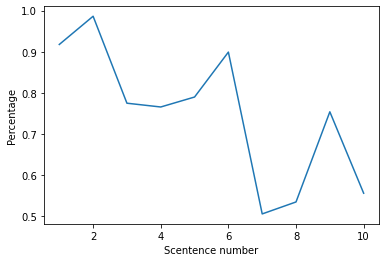

In [ ]:
run_sentiment_ananlysis(text)

In [ ]:
from collections import Counter

In [ ]:
def run_emotion_ananlysis(paragraph):

  paragraph = paragraph.replace('\n', ' ')
  paragraph = paragraph.replace(',', '')
  scentences = paragraph.split('.')[:-1]
  result = []
  for scentence in scentences:
    result.append(predict_emotion(scentence))
  fig = plt.figure(figsize = (10, 5))
  print(dict(Counter(result)))
  plt.bar(dict(Counter(result)).keys(), dict(Counter(result)).values(), color ='blue',
          width = 0.5)
  plt.xlabel("Scentences")
  plt.ylabel("Emotion")
  plt.show()


Input Text: 	My school is my second home and is the most popular organization that homes my teachers and guardians
Emotion: 	⚽️ Playful/Excited

Input Text: 	           It is the oldest and the most popular school in the city
Emotion: 	⚽️ Playful/Excited

Input Text: 	           I even enjoy visiting my school during the holidays
Emotion: 	😄 Happy

Input Text: 	           The name of my school is Bishop Cottons Boys High School and is located at the heart of the city
Emotion: 	😄 Happy

Input Text: 	           My school conducts numerous annual sports championships debates quiz competitions and group discussions regularly
Emotion: 	😄 Happy

Input Text: 	           Teachers take regular sessions on discipline health cleanliness and manners in addition to regular subjects           My school conducts Physical Education class once every week
Emotion: 	😄 Happy

Input Text: 	           My school has strict measures and regulations which we need to follow regularly
Emotion: 	😞 Annoyed/Sad

I

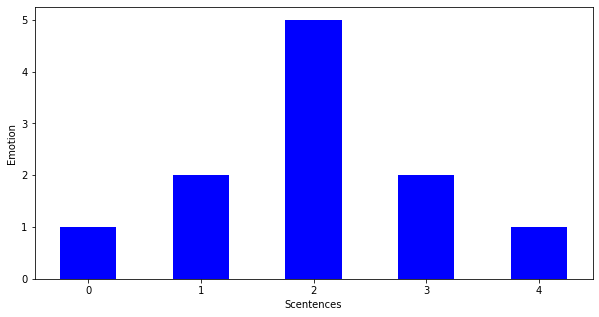

In [ ]:
run_emotion_ananlysis(text)